In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_functionl
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)
Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [3]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def variable_summaries(var, name,dorelu):
  with tf.name_scope("summaries"):
    mean = tf.reduce_mean(var)
    tf.scalar_summary('mean/' + name, mean)
    if dorelu==1:
        var = tf.nn.relu6(var)
        
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_sum(tf.square(var - mean)))
    tf.scalar_summary('sttdev/' + name, stddev)
    tf.scalar_summary('max/' + name, tf.reduce_max(var))
    tf.scalar_summary('min/' + name, tf.reduce_min(var))
    tf.scalar_summary('sparsity/'+ name, tf.nn.zero_fraction(var))
    tf.histogram_summary(name, var)
    
def variable_summaries_list(varDict):
  for name,var in varDict.items():
    with tf.name_scope("summaries"):
      mean = tf.reduce_mean(var)
      tf.scalar_summary(name + 'mean/', mean)
      tf.scalar_summary(name + 'sttdev/',  tf.sqrt(tf.reduce_sum(tf.square(var - mean))))
      tf.scalar_summary(name + 'max/', tf.reduce_max(var))
      tf.scalar_summary(name + 'min/', tf.reduce_min(var))
      tf.scalar_summary(name + 'sparsity/', tf.nn.zero_fraction(var))
      tf.histogram_summary(name, var)

def testAccuracy(arrayValue,stopthresh=0.5):
  #   print('V1, V2, Diff, Std = (%.03f, %.03f, %.03f, %.03f)' % 
  #         (arrayValue[-1], np.mean(arrayValue[-7:-2]),np.abs(arrayValue[-1]-np.mean(arrayValue[-7:-2])), np.std(arrayValue[-7:-2])))
  notChanging = np.abs(arrayValue[-1]-np.mean(arrayValue[-7:-2])) < stopthresh*np.std(arrayValue[-7:-2])
  slopeNegative = np.mean(np.gradient(arrayValue[-7:-1]))<0
  return notChanging|slopeNegative
  

In [4]:
train_dataset

array([[-0.5       , -0.5       , -0.5       , ..., -0.49607843,
        -0.48823529, -0.5       ],
       [ 0.5       ,  0.5       ,  0.5       , ...,  0.49215686,
         0.5       ,  0.39411765],
       [-0.5       , -0.5       , -0.5       , ...,  0.5       ,
         0.49607843,  0.31176472],
       ..., 
       [ 0.24509804,  0.5       ,  0.49215686, ..., -0.5       ,
        -0.5       , -0.5       ],
       [-0.5       , -0.5       , -0.5       , ..., -0.44117647,
        -0.5       , -0.5       ],
       [-0.5       , -0.5       , -0.48823529, ..., -0.5       ,
        -0.5       , -0.5       ]], dtype=float32)

In [5]:
def model_1d(data, w1,w2,w3,b1,b2,b3, dropoutList):
     # Hidden Layer Training computation.
  vals = tf.matmul(data, w1) + b1
  hidden1 = tf.nn.dropout(tf.nn.tanh(vals),dropoutList[0])            
  vals2 = tf.matmul(hidden1,w2)+b2
  hidden2 = tf.nn.dropout(tf.nn.tanh(vals2),dropoutList[1])            
  vals3 = tf.matmul(hidden2,w3)+b3
#  hidden3 = tf.nn.relu(vals3)
#  if dropout:
#        hidden3 = tf.nn.relu(vals3)
#  vals4 = tf.matmul(tf.nn.dropout(hidden3,.25),weights4)+biases4
  return vals3

def exploreData(datasetDict, paramDict):
  doWrite = 0; # this isn't working
  tf.reset_default_graph()
  tf.Graph().as_default()
  graph = tf.Graph()
  learnRate = paramDict['learnRate']
  with graph.as_default():
    # With Priors
    # The datas
    dropoutList = [1,1,1];
    betalist = [5e-4,5e-4,5e-4]
    tf_trainDataset = tf.constant(datasetDict['trainDataset'])
    tf_trainLabels = tf.constant(datasetDict['trainLabels'])
    train_subset = len(datasetDict['trainLabels'])

    tf_trainDatasetRed = tf.constant(datasetDict['trainDatasetRed'])
    tf_trainLabelsRed = tf.constant(datasetDict['trainLabelsRed'])
    tf_validDataset = tf.constant(datasetDict['validDataset'])
    tf_validLabels = tf.constant(datasetDict['validLabels'])
    tf_testDataset = tf.constant(datasetDict['testDataset'])
    tf_testLabels = tf.constant(datasetDict['testLabels'])
    
    num_neurons = [image_size * image_size, 512, 256, num_labels]
    # Variables.
    #Initialize variables
    layer_name = 'layer1_wprior'
    
     # Variables.
    w11 = tf.Variable(tf.random_normal([num_neurons[0], num_neurons[1]], 0, 2.0/np.sqrt(num_neurons[0]+num_neurons[1])))
    b11 = tf.Variable(tf.zeros([num_neurons[1]]))
    w12 = tf.Variable(tf.random_normal([num_neurons[1], num_neurons[2]], 0, 2.0/np.sqrt(num_neurons[1]+num_neurons[2])))
    b12 = tf.Variable(tf.zeros([num_neurons[2]]))
    w13 = tf.Variable(tf.random_normal([num_neurons[2], num_neurons[3]], 0, 2.0/np.sqrt(num_neurons[2]+num_neurons[3])))
    b13 = tf.Variable(tf.zeros([num_neurons[3]]))
    
    # All priors are given the same initial value.
    priors = tf.Variable(tf.ones([train_subset])*np.float(paramDict['priorInit']),name='priors')
#     priors = tf.add(priors,tf.random_normal(train_subset,0,.05))
    # Training computation.
    # Find the classification estimation 'z' value
    logits = model_1d(tf_trainDataset, w11,w12,w13,b11,b12,b13, dropoutList)
    # Calculate the cross-entropy loss. 
#     loss1 = tf.reduce_mean(tf.mul(
#               tf.nn.relu6(priors*6),tf.nn.softmax_cross_entropy_with_logits(logits, tf_trainLabels)
#                                   )
#                          )/tf.reduce_mean(tf.nn.relu6(priors*6))
    loss1 = tf.reduce_mean(tf.mul(
              tf.nn.sigmoid(priors),tf.nn.softmax_cross_entropy_with_logits(logits, tf_trainLabels)
                                  )
                         )/tf.reduce_mean(tf.nn.sigmoid(priors))+betalist[0]*tf.nn.l2_loss(w11)+betalist[1]*tf.nn.l2_loss(w12)+betalist[2]*tf.nn.l2_loss(w13)
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer1 = tf.train.GradientDescentOptimizer(learnRate).minimize(loss1)
    # Predictions for the training, validation. 
    # Do not use the priors to perform classification!
    train_prediction1 = tf.nn.softmax(logits)
    valid_prediction1 = tf.nn.softmax(model_1d(tf_validDataset, w11,w12,w13,b11,b12,b13, [1,1,1]))
    test_prediction1 = tf.nn.softmax(model_1d(tf_testDataset, w11,w12,w13,b11,b12,b13, [1,1,1]))

    # WITHOUT PRIORS
    layer_name = 'layer1_normal'
    w21 = tf.Variable(w11.initialized_value())
    b21 = tf.Variable(b11.initialized_value())
    w22 = tf.Variable(w12.initialized_value())
    b22 = tf.Variable(b12.initialized_value())
    w23 = tf.Variable(w13.initialized_value())
    b23 = tf.Variable(b13.initialized_value())
    
    # Training computation.
    # Find the classification estimation 'z' value
    logits2 = model_1d(tf_trainDataset, w21,w22,w23,b21,b22,b23, dropoutList)

    # Calculate the cross-entropy loss. 
    loss2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits2, tf_trainLabels))+betalist[0]*tf.nn.l2_loss(w21)+betalist[1]*tf.nn.l2_loss(w22)+betalist[2]*tf.nn.l2_loss(w23)

    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer2 = tf.train.GradientDescentOptimizer(learnRate).minimize(loss2)
    # Predictions for the training, validation. 
    train_prediction2 = tf.nn.softmax(logits2)
    valid_prediction2 = tf.nn.softmax(model_1d(tf_validDataset, w21,w22,w23,b21,b22,b23, [1,1,1]))
    test_prediction2 = tf.nn.softmax(model_1d(tf_testDataset, w21,w22,w23,b21,b22,b23, [1,1,1]))                                  

    # WITHOUT PRIORS REDUCED DATA
    layer_name = 'layer1_normal_reducedDatas'
    w31 = tf.Variable(w11.initialized_value())
    b31 = tf.Variable(b11.initialized_value())
    w32 = tf.Variable(w12.initialized_value())
    b32 = tf.Variable(b12.initialized_value())
    w33 = tf.Variable(w13.initialized_value())
    b33 = tf.Variable(b13.initialized_value())
    # Training computation.
    logits3 = model_1d(tf_trainDatasetRed, w21,w22,w23,b21,b22,b23, dropoutList)

    # Calculate the cross-entropy loss. 
    loss3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits3, tf_trainLabelsRed))+100*betalist[0]*tf.nn.l2_loss(w31)+100*betalist[1]*tf.nn.l2_loss(w32)+100*betalist[2]*tf.nn.l2_loss(w33)   
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer3 = tf.train.GradientDescentOptimizer(learnRate).minimize(loss3)
    # Predictions for the training, validation. 
    train_prediction3 = tf.nn.softmax(logits3)
    valid_prediction3 = tf.nn.softmax(model_1d(tf_validDataset, w31,w32,w33,b31,b32,b33, [1,1,1]))
    test_prediction3 = tf.nn.softmax(model_1d(tf_testDataset, w31,w32,w33,b31,b32,b33, [1,1,1]))  

  train_acc_priors = []
  valid_acc_priors = []
  train_acc_normal = []
  valid_acc_normal = []
  train_acc_normal_red = []
  valid_acc_normal_red = []
#   num_steps = 40000
  num_steps = 1000
  train1 = True
  train2 = True
  train3 = True
  with tf.Session(graph=graph) as session:
    # Initialize
    tf.initialize_all_variables().run()    
    summary_op = tf.merge_all_summaries()
    train_dir = 'tmp'
    summary_writer = tf.train.SummaryWriter(train_dir, session.graph)  
    print('Initialized')
    modelPriorLastStep = num_steps
    modelNormalLastStep = num_steps
    modelNormalRedLastStep = num_steps

    for step in range(num_steps):
      # Run the computations.
      if train1:
        # With priors
        _, lvl1, predictions1 = session.run([optimizer1, loss1, train_prediction1])
      if train2:
        # Without priors
        _, lvl2, predictions2 = session.run([optimizer2, loss2, train_prediction2])
      if train3:
        # Without priors
        _, lvl3, predictions3 = session.run([optimizer3, loss3, train_prediction3])

      if (step % 10 == 0):
        if doWrite:
          summary_str = session.run(summary_op)
          summary_writer.add_summary(summary_str, step)  

        acc1 = accuracy(predictions1, datasetDict['trainLabels'])
        acc2 =  accuracy(valid_prediction1.eval(), datasetDict['validLabels'])
        train_acc_priors.append(acc1)
        valid_acc_priors.append(acc2)
        print('With prior. Loss at step %d: %f . Training accuracy: %.1f%% . Validation accuracy: %.1f%%' % (step, lvl1 , acc1, acc2))

        acc1 = accuracy(predictions2, datasetDict['trainLabels'])
        acc2 =  accuracy(valid_prediction2.eval(), datasetDict['validLabels'])
        train_acc_normal.append(acc1)
        valid_acc_normal.append(acc2)
        print('Nope prior. Loss at step %d: %f . Training accuracy: %.1f%% . Validation accuracy: %.1f%%' % (step, lvl2 , acc1, acc2))

        acc1 = accuracy(predictions3, trainLabelsRed)
        acc2 =  accuracy(valid_prediction3.eval(), datasetDict['validLabels'])
        train_acc_normal_red.append(acc1)
        valid_acc_normal_red.append(acc2)
        print('Nope prior. Loss at step %d: %f . Training accuracy: %.1f%% . Validation accuracy: %.1f%%' % (step, lvl3 , acc1, acc2))
      stopthresh = 0.5;
      if step > 70:
        if testAccuracy(train_acc_priors) and train1:
          train1 = False
          modelPriorLastStep = step
          print('No longer training w/ priors')
        if testAccuracy(train_acc_normal) and train2:
          train2 = False
          modelNormalLastStep = step
          print('No longer training w/ normal method')
        if testAccuracy(train_acc_normal_red) and train3:
          train3 = False
          modelNormalRedLastStep = step
          print('No longer training w/ normal + reduced data')
      if train1==False and train2==False and train3==False:
        print('Stopping Training at step ', step)
        break;

    tp1 = accuracy(test_prediction1.eval(), dDict['testLabels']);
    tp2 = accuracy(test_prediction2.eval(), dDict['testLabels']);
    tp3 = accuracy(test_prediction3.eval(), dDict['testLabels'])
    print('Test accuracy with prior: %.1f%%' % tp1)
    print('Test accuracy no prior: %.1f%%' % tp2)
    print('Test accuracy no prior on small data: %.1f%%' % tp3)
    accDict = {'trainAcc_priors': train_acc_priors, 'validAcc_prior': valid_acc_priors,
              'trainAcc_normal': train_acc_normal, 'validAcc_normal': valid_acc_normal,
              'trainAcc_normalRed': train_acc_normal_red, 'validAcc_normalRed': valid_acc_normal_red, 
              'testAcc_prior': tp1, 'testAcc_normal': tp2, 'testAcc_normalRed': tp3,
            'modelPriorLastStep': modelPriorLastStep, 'modelNormalLastStep': modelNormalLastStep,'modelNormalRedLastStep': modelNormalRedLastStep}
    
  return accDict



In [6]:

dDict = dict()
dDict['validDataset'] = valid_dataset
dDict['validLabels'] = valid_labels
dDict['testDataset'] = test_dataset
dDict['testLabels'] = test_labels


train_subset = 10000
train_dataset2 = train_dataset[:train_subset, :]
train_labels2 = train_labels[:train_subset]
dDict['trainDataset'] = train_dataset2

numTest = 5;
fracBadList = np.linspace(0,.8, num=numTest) 
fracBadList = [0.0]
outList = []
pDict = dict()
for i, fracBad in enumerate(fracBadList):
  pDict['priorInit'] = (1-fracBad)*.9
  pDict['learnRate'] = 0.5
  nBad = np.int(fracBad*train_labels2.shape[0])
  print('Mislabeling %0.1f of data or %i / %i examples' % (fracBad, nBad, train_subset))
  rangeNess = np.arange(train_labels2.shape[0])
  np.random.shuffle(rangeNess)
  randomBreak = rangeNess[:nBad]
  trainL = train_labels2
  for i, rb in enumerate(randomBreak):
    trainL[rb][:] = trainL[rb][np.random.permutation(10)];
  trainDatasetRed = np.delete(train_dataset2,randomBreak,0)
  trainLabelsRed = np.delete(train_labels2,randomBreak,0)

  dDict['trainLabels'] = trainL
  dDict['trainDatasetRed'] = trainDatasetRed
  dDict['trainLabelsRed'] = trainLabelsRed  
  ar = exploreData(dDict, pDict)
  outList.append(ar)
  with open('results_nnn_0.0dropout_0.0.dat', 'wb') as outfile:
    pickle.dump(outList, outfile, protocol=pickle.HIGHEST_PROTOCOL)

Mislabeling 0.0 of data or 0 / 10000 examples
Initialized
With prior. Loss at step 0: 3.339994 . Training accuracy: 10.7% . Validation accuracy: 55.3%
Nope prior. Loss at step 0: 3.339957 . Training accuracy: 10.7% . Validation accuracy: 63.0%
Nope prior. Loss at step 0: 50.945671 . Training accuracy: 55.6% . Validation accuracy: 10.7%
With prior. Loss at step 10: 1.551033 . Training accuracy: 71.0% . Validation accuracy: 70.0%
Nope prior. Loss at step 10: 1.155748 . Training accuracy: 80.8% . Validation accuracy: 79.2%
Nope prior. Loss at step 10: 30.198553 . Training accuracy: 80.8% . Validation accuracy: 10.5%
With prior. Loss at step 20: 1.163072 . Training accuracy: 80.6% . Validation accuracy: 78.9%
Nope prior. Loss at step 20: 1.013592 . Training accuracy: 85.5% . Validation accuracy: 82.8%
Nope prior. Loss at step 20: 18.306084 . Training accuracy: 85.7% . Validation accuracy: 10.6%
With prior. Loss at step 30: 1.045035 . Training accuracy: 84.4% . Validation accuracy: 82.2%
No

In [7]:
outList[0].items()
import pandas as pd

ar

In [8]:
with open('test.dat', 'wb') as outfile:
    pickle.dump(outList, outfile, protocol=pickle.HIGHEST_PROTOCOL)

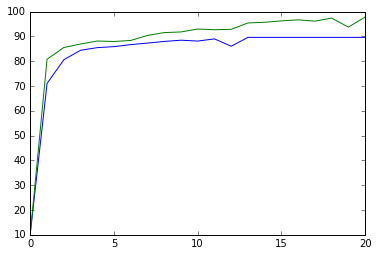

In [9]:
import matplotlib.pyplot as plt
plt.plot(ar['trainAcc_priors'])
plt.plot(ar['trainAcc_normal'])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ar['trainAcc_priors'])
plt.plot(ar['trainAcc_normal'])

In [10]:
ar.keys()

dict_keys(['testAcc_normalRed', 'validAcc_normalRed', 'trainAcc_normal', 'modelPriorLastStep', 'testAcc_prior', 'trainAcc_normalRed', 'trainAcc_priors', 'modelNormalLastStep', 'modelNormalRedLastStep', 'testAcc_normal', 'validAcc_prior', 'validAcc_normal'])

When using 50% dropout, here were the results:
'''
Stopping Training at step  320
Test accuracy with prior: 89.7%
Test accuracy no prior: 89.9%
Test accuracy no prior on small data: 8.6%
'''

When using 0% dropout, here were the results:
'''
Stopping Training at step  200
Test accuracy with prior: 89.5%
Test accuracy no prior: 90.3%
Test accuracy no prior on small data: 10.4%
'''